In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [11]:
# Load the data from CSV files
atom_df = pd.read_csv('data/atom.csv')
whatsapp_df = pd.read_csv('data/whatsapp.csv')
codedx_df = pd.read_csv('data/codedx.csv')

In [12]:
# Concatenate the dataframes
df = pd.concat([atom_df, whatsapp_df, codedx_df], ignore_index=True)

# Drop 'Unnamed column'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop the 'Description' column
df.drop(columns=['Description'], inplace=True)

# Handle missing values for categorical features with a new category 'missing'
categorical_features = ['Severity', 'Tool Category', 'Tool Name', 'Rule Name']
categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# Handle missing values for numerical feature (CWE) with median
numerical_imputer = SimpleImputer(strategy='median')
df['CWE'] = numerical_imputer.fit_transform(df[['CWE']])

In [13]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns= df.select_dtypes(include=['object']).columns.difference(['Description','Status']))

In [14]:
X = df.drop(columns=['Status'])
y = df['Status']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [32]:
# Hyperparameter tuning for Decision Tree: using Grid search

# Define the model - randomness being set to 42
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9399546722454672
Test Accuracy: 0.9408333333333333


In [33]:
# Hyperparameter tuning for Decision Tree: using Random search

# Define the model - randomness being set to 42
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the parameter distribution
param_dist = {
    'max_depth': [None] + list(range(1, 21)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy']
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(dt_classifier, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

# Use the best estimator to make predictions
best_estimator = random_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score: 0.9399546722454672
Test Accuracy: 0.9408333333333333


In [34]:

# Hyperparameter tuning for Random Forest: using Grid search

# Define the model - randomness being set to 42
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method for sampling data points (with or without replacement)
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9416213389121338
Test Accuracy: 0.9408333333333333


In [35]:
# Hyperparameter tuning for Random Forest: using Random search

# Define the model - randomness being set to 42
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),  # Uniformly sampled from this range
    'max_depth': [None] + list(range(10, 31, 10)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

# Use the best estimator to make predictions
best_estimator = random_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 288}
Best score: 0.9416213389121338
Test Accuracy: 0.9408333333333333


In [36]:
# Model training and evaluation

# Decision Tree
dt_classifier = DecisionTreeClassifier(criterion = 'gini', max_depth = None, min_samples_leaf = 1, min_samples_split = 2)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
print("Decision Tree Classifier Results:")
print(classification_report(y_test, dt_predictions))

# Random Forest
rf_classifier = RandomForestClassifier(bootstrap = True, max_depth = 30, min_samples_leaf = 1, min_samples_split = 9, n_estimators = 288)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print("Random Forest Classifier Results:")
print(classification_report(y_test, rf_predictions))

Decision Tree Classifier Results:
                precision    recall  f1-score   support

     escalated       0.96      0.95      0.96       801
false-positive       0.90      0.92      0.91       399

      accuracy                           0.94      1200
     macro avg       0.93      0.94      0.93      1200
  weighted avg       0.94      0.94      0.94      1200

Random Forest Classifier Results:
                precision    recall  f1-score   support

     escalated       0.96      0.95      0.96       801
false-positive       0.90      0.92      0.91       399

      accuracy                           0.94      1200
     macro avg       0.93      0.94      0.93      1200
  weighted avg       0.94      0.94      0.94      1200



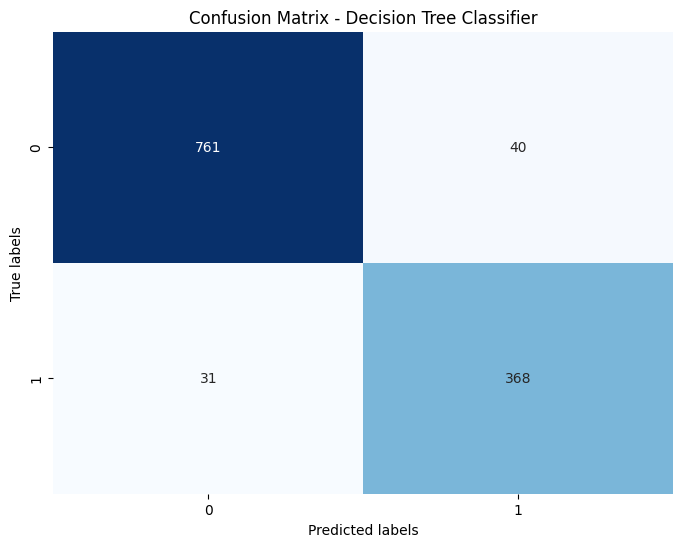

In [37]:
# Confusion matrix for Decision Tree
dt_conf_matrix = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

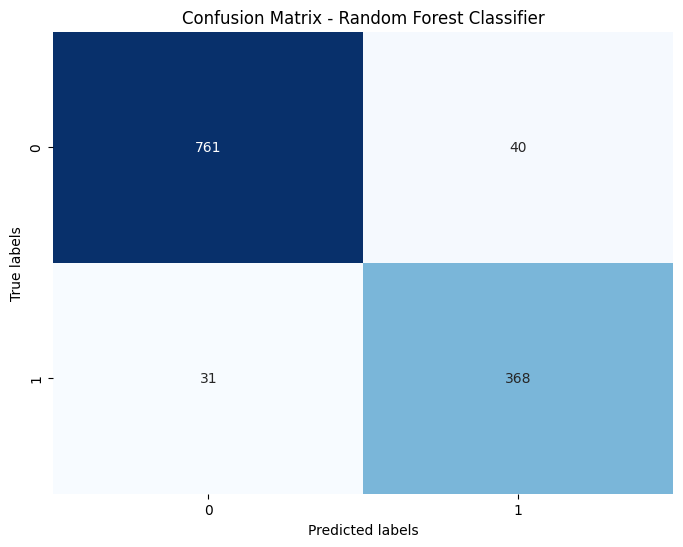

In [38]:
# Confusion matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()